# Building your Deep Neural Network: Step by Step

In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

In [2]:
train_dataset = h5py.File('train_catvnoncat.h5', "r")
x_train = np.array(train_dataset["train_set_x"][:]) 
y_train = np.array(train_dataset["train_set_y"][:])

test_dataset = h5py.File('test_catvnoncat.h5', "r")
x_test = np.array(test_dataset["test_set_x"][:]) 
y_test = np.array(test_dataset["test_set_y"][:])

In [3]:
X_train = np.reshape(x_train, (x_train.shape[0], -1))
Y_train = np.reshape(y_train,(-1,1))

X_test = np.reshape(x_test, (x_test.shape[0], -1))
Y_test = np.reshape(y_test,(-1,1))

It's not a cat!


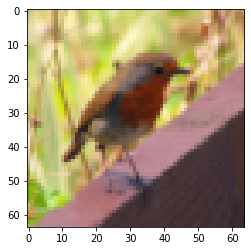

In [4]:
index = 10
plt.imshow(np.reshape(X_train[index,:], (64,64,3)))
print("It's{} a cat!".format((1-Y_train[index,0])*' not'))

In [5]:
class Lambda():
    
    def __init__(self):
        self.weights = []
                
    def __call__(self, inputs):
        return inputs/255.
    
class Dense1():
    
    def __init__(self, units):
        self.units = units
        self.weights = []
        self.built = False
        
    def add_weight(self, shape):
        var_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=var_init, trainable=True)
        
    def build(self, input_dims):
        self.w = self.add_weight(shape=(input_dims, self.units))
        self.weights.append(self.w)
        self.b = self.add_weight(shape=(1, self.units))
        self.weights.append(self.b)
        self.built = True

    def __call__(self, inputs):
        if not self.built:
            self.build(input_dims=inputs.shape[1])
        z = tf.matmul(inputs, self.w) + self.b
        return tf.maximum(0.,z)

class Dense2():
    
    def __init__(self, units):
        self.units = units
        self.weights = []
        self.built = False
        
    def add_weight(self, shape):
        var_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=var_init, trainable=True)
        
    def build(self, input_dims):
        self.w = self.add_weight(shape=(input_dims, self.units))
        self.weights.append(self.w)
        self.b = self.add_weight(shape=(1, self.units))
        self.weights.append(self.b)
        self.built = True

    def __call__(self, inputs):
        if not self.built:
            self.build(input_dims=inputs.shape[1])
        z = tf.matmul(inputs, self.w) + self.b
        return tf.math.sigmoid(z)

In [6]:
class BinaryCrossEntropy():
                    
    def __call__(self, y_true, y_pred):
        return -tf.math.reduce_mean(y_true*tf.math.log(y_pred) + (1-y_true)*tf.math.log(1-y_pred))

In [7]:
class BinaryAccuracy():
    
    def __init__(self, threshold):
        self.threshold = threshold
                    
    def __call__(self, y_true, y_pred):
        y_pred_ = tf.sign(1+tf.sign(y_pred-self.threshold))
        return tf.math.reduce_mean(1-tf.square(tf.sign(y_true-y_pred_))) 

In [8]:
class SGD():

    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        self.stop_training = False
        
    def apply_gradients(self, grads_and_vars):
        list_grads_and_vars = list(grads_and_vars)
        for grad, var in list_grads_and_vars:
            var.assign(var - self.learning_rate*grad)

In [9]:
class ProgbarPrint():

    def __init__(self, model):
        self.model = model
    
    def on_epoch_begin(self, epoch):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs):
        now = tf.timestamp()
        time = now - self.start_time
        tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
        tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
        
class History():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class ReduceLROnPlateau():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class EarlyStopping():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [10]:
class Model():
    
    def __init__(self):
        self.h1 = Lambda()
        self.h2 = Dense1(units=20)
        self.h3 = Dense1(units=7)
        self.h4 = Dense1(units=5)
        self.h5 = Dense2(units=Y_train.shape[1])
        self.layers = [self.h1, self.h2, self.h3, self.h4, self.h5]
        self.weights = []
        self.built = False
     
    def build(self):
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        self.built = True
        
    def __call__(self, inputs): 
        a1 = self.h1(inputs)
        a2 = self.h2(a1)
        a3 = self.h3(a2)
        a4 = self.h4(a3)
        y = self.h5(a4)
        if not self.built:
            self.build()
        return y 
                
    def train_step(self, X, Y):
        with tf.GradientTape() as tape:
            H = self(X)
            loss = self.loss(Y, H)
        grads = tape.gradient(loss, self.weights)
        self.optimizer.apply_gradients(zip(grads, self.weights))
        H = self(X)
        loss = self.loss(Y, H)
        metric = self.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs
        
    def fit(self, X, Y, epochs=10000, learning_rate=0.0075):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.loss = BinaryCrossEntropy()
        self.metric = BinaryAccuracy(threshold=0.5)
        self.optimizer = SGD(learning_rate=self.learning_rate) 
        self.callbacks = [ProgbarPrint(model=self),
                          History(model=self),
                          ReduceLROnPlateau(model=self, patience=500, error=0.0001, reduce_factor=0.1, min_learning_rate=0.001),
                          EarlyStopping(model=self, patience=1000, error=0.0001)]
        tf.print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
        
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [11]:
model = Model()

model.fit(X_train, Y_train)

Train on 209 samples
Epochs 1/10000 - Loss: 0.7064672708511353 - Metric: 0.3444976210594177
----- 0.056s -----
Epochs 2/10000 - Loss: 0.7062342166900635 - Metric: 0.3444976210594177
----- 0.015s -----
Epochs 3/10000 - Loss: 0.7060020565986633 - Metric: 0.3444976210594177
----- 0.018s -----
Epochs 4/10000 - Loss: 0.70577073097229 - Metric: 0.3444976210594177
----- 0.019s -----
Epochs 5/10000 - Loss: 0.7055402398109436 - Metric: 0.3444976210594177
----- 0.017s -----
Epochs 6/10000 - Loss: 0.7053106427192688 - Metric: 0.3444976210594177
----- 0.019s -----
Epochs 7/10000 - Loss: 0.7050819993019104 - Metric: 0.3444976210594177
----- 0.016s -----
Epochs 8/10000 - Loss: 0.7048541903495789 - Metric: 0.3444976210594177
----- 0.017s -----
Epochs 9/10000 - Loss: 0.704627275466919 - Metric: 0.3444976210594177
----- 0.016s -----
Epochs 10/10000 - Loss: 0.7044012546539307 - Metric: 0.3444976210594177
----- 0.016s -----
Epochs 11/10000 - Loss: 0.704176127910614 - Metric: 0.3444976210594177
----- 0.01

----- 0.017s -----
Epochs 92/10000 - Loss: 0.6885027885437012 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 93/10000 - Loss: 0.6883378028869629 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 94/10000 - Loss: 0.6881735324859619 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 95/10000 - Loss: 0.6880099177360535 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 96/10000 - Loss: 0.6878469586372375 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 97/10000 - Loss: 0.6876844167709351 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 98/10000 - Loss: 0.6875226497650146 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 99/10000 - Loss: 0.6873613595962524 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 100/10000 - Loss: 0.6872007846832275 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 101/10000 - Loss: 0.6870409846305847 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 102/10000 - Loss: 0.6868816018104553 - Metric: 0.6555023789405

----- 0.018s -----
Epochs 182/10000 - Loss: 0.6758949160575867 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 183/10000 - Loss: 0.6757774353027344 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 184/10000 - Loss: 0.6756604313850403 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 185/10000 - Loss: 0.6755438446998596 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 186/10000 - Loss: 0.6754277348518372 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 187/10000 - Loss: 0.6753120422363281 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 188/10000 - Loss: 0.6751965880393982 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 189/10000 - Loss: 0.6750818490982056 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 190/10000 - Loss: 0.6749674081802368 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 191/10000 - Loss: 0.6748533844947815 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 192/10000 - Loss: 0.6747397780418396 - Metric: 0.65550

Epochs 271/10000 - Loss: 0.6669905185699463 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 272/10000 - Loss: 0.6669064164161682 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 273/10000 - Loss: 0.666822612285614 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 274/10000 - Loss: 0.6667390465736389 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 275/10000 - Loss: 0.6666558980941772 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 276/10000 - Loss: 0.6665729880332947 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 277/10000 - Loss: 0.666490375995636 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 278/10000 - Loss: 0.666408121585846 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 279/10000 - Loss: 0.6663262248039246 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 280/10000 - Loss: 0.6662445068359375 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 281/10000 - Loss: 0.6661631464958191 - Metric: 0.6555023789405823
----- 0.01

----- 0.015s -----
Epochs 361/10000 - Loss: 0.6605439782142639 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 362/10000 - Loss: 0.6604837775230408 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 363/10000 - Loss: 0.6604238152503967 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 364/10000 - Loss: 0.660364031791687 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 365/10000 - Loss: 0.6603045463562012 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 366/10000 - Loss: 0.6602452397346497 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 367/10000 - Loss: 0.6601861119270325 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 368/10000 - Loss: 0.6601272821426392 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 369/10000 - Loss: 0.6600685715675354 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 370/10000 - Loss: 0.6600100994110107 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 371/10000 - Loss: 0.6599519848823547 - Metric: 0.655502

Epochs 450/10000 - Loss: 0.65597003698349 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 451/10000 - Loss: 0.6559267044067383 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 452/10000 - Loss: 0.6558835506439209 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 453/10000 - Loss: 0.6558405160903931 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 454/10000 - Loss: 0.6557976603507996 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 455/10000 - Loss: 0.6557549238204956 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 456/10000 - Loss: 0.6557124257087708 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 457/10000 - Loss: 0.6556699275970459 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 458/10000 - Loss: 0.6556278467178345 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 459/10000 - Loss: 0.6555856466293335 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 460/10000 - Loss: 0.6555437445640564 - Metric: 0.6555023789405823
----- 0.0

----- 0.015s -----
Epochs 540/10000 - Loss: 0.6526415348052979 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 541/10000 - Loss: 0.6526103615760803 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 542/10000 - Loss: 0.6525793671607971 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 543/10000 - Loss: 0.6525483727455139 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 544/10000 - Loss: 0.6525174975395203 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 545/10000 - Loss: 0.6524868011474609 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 546/10000 - Loss: 0.6524561643600464 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 547/10000 - Loss: 0.6524256467819214 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 548/10000 - Loss: 0.6523953676223755 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 549/10000 - Loss: 0.65236496925354 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 550/10000 - Loss: 0.6523348689079285 - Metric: 0.6555023

Epochs 629/10000 - Loss: 0.6502670049667358 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 630/10000 - Loss: 0.6502444744110107 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 631/10000 - Loss: 0.6502218842506409 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 632/10000 - Loss: 0.6501994729042053 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 633/10000 - Loss: 0.6501772999763489 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 634/10000 - Loss: 0.6501550078392029 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 635/10000 - Loss: 0.6501328349113464 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 636/10000 - Loss: 0.6501107811927795 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 637/10000 - Loss: 0.6500887870788574 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 638/10000 - Loss: 0.6500668525695801 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 639/10000 - Loss: 0.6500449776649475 - Metric: 0.6555023789405823
----- 0

----- 0.015s -----
Epochs 719/10000 - Loss: 0.6485302448272705 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 720/10000 - Loss: 0.6485138535499573 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 721/10000 - Loss: 0.6484976410865784 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 722/10000 - Loss: 0.6484813690185547 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 723/10000 - Loss: 0.6484653353691101 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 724/10000 - Loss: 0.6484492421150208 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 725/10000 - Loss: 0.648433268070221 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 726/10000 - Loss: 0.6484171748161316 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 727/10000 - Loss: 0.6484013795852661 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 728/10000 - Loss: 0.6483855247497559 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 729/10000 - Loss: 0.6483696699142456 - Metric: 0.655502

----- 0.016s -----
Epochs 809/10000 - Loss: 0.6472735404968262 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 810/10000 - Loss: 0.6472616791725159 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 811/10000 - Loss: 0.6472499370574951 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 812/10000 - Loss: 0.6472381949424744 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 813/10000 - Loss: 0.6472264528274536 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 814/10000 - Loss: 0.6472147703170776 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 815/10000 - Loss: 0.6472031474113464 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 816/10000 - Loss: 0.64719158411026 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 817/10000 - Loss: 0.6471801400184631 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 818/10000 - Loss: 0.6471686363220215 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 819/10000 - Loss: 0.6471571922302246 - Metric: 0.6555023

----- 0.015s -----
Epochs 899/10000 - Loss: 0.6463625431060791 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 900/10000 - Loss: 0.6463538408279419 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 901/10000 - Loss: 0.6463453769683838 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 902/10000 - Loss: 0.6463369131088257 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 903/10000 - Loss: 0.6463284492492676 - Metric: 0.6555023789405823
----- 0.025s -----
Epochs 904/10000 - Loss: 0.6463198661804199 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 905/10000 - Loss: 0.6463114619255066 - Metric: 0.6555023789405823
----- 0.023s -----
Epochs 906/10000 - Loss: 0.646303117275238 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 907/10000 - Loss: 0.6462947726249695 - Metric: 0.6555023789405823
----- 0.024s -----
Epochs 908/10000 - Loss: 0.6462864279747009 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 909/10000 - Loss: 0.6462780237197876 - Metric: 0.6555023

Epochs 988/10000 - Loss: 0.6457068920135498 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 989/10000 - Loss: 0.6457006931304932 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 990/10000 - Loss: 0.6456944346427917 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 991/10000 - Loss: 0.6456881165504456 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 992/10000 - Loss: 0.6456820368766785 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 993/10000 - Loss: 0.645675778388977 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 994/10000 - Loss: 0.6456695795059204 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 995/10000 - Loss: 0.6456635594367981 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 996/10000 - Loss: 0.6456575393676758 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 997/10000 - Loss: 0.6456514000892639 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 998/10000 - Loss: 0.645645260810852 - Metric: 0.6555023789405823
----- 0.0

----- 0.016s -----
Epochs 1077/10000 - Loss: 0.6452279090881348 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1078/10000 - Loss: 0.6452233195304871 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1079/10000 - Loss: 0.6452187895774841 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1080/10000 - Loss: 0.6452142000198364 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1081/10000 - Loss: 0.6452097296714783 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1082/10000 - Loss: 0.6452051997184753 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1083/10000 - Loss: 0.6452006697654724 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1084/10000 - Loss: 0.6451961994171143 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1085/10000 - Loss: 0.6451916694641113 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1086/10000 - Loss: 0.6451873183250427 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1087/10000 - Loss: 0.6451828479766846 - Metr

----- 0.02s -----
Epochs 1166/10000 - Loss: 0.6448772549629211 - Metric: 0.6555023789405823
----- 0.021s -----
Epochs 1167/10000 - Loss: 0.644873857498169 - Metric: 0.6555023789405823
----- 0.023s -----
Epochs 1168/10000 - Loss: 0.6448705196380615 - Metric: 0.6555023789405823
----- 0.024s -----
Epochs 1169/10000 - Loss: 0.6448672413825989 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1170/10000 - Loss: 0.6448637843132019 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1171/10000 - Loss: 0.644860565662384 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 1172/10000 - Loss: 0.6448572278022766 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1173/10000 - Loss: 0.6448538899421692 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1174/10000 - Loss: 0.6448506712913513 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1175/10000 - Loss: 0.6448473930358887 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1176/10000 - Loss: 0.6448441743850708 - Metric: 

----- 0.016s -----
Epochs 1255/10000 - Loss: 0.6446200013160706 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1256/10000 - Loss: 0.64461749792099 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1257/10000 - Loss: 0.6446150541305542 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1258/10000 - Loss: 0.6446126103401184 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1259/10000 - Loss: 0.6446101665496826 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1260/10000 - Loss: 0.644607663154602 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1261/10000 - Loss: 0.644605278968811 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1262/10000 - Loss: 0.64460289478302 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1263/10000 - Loss: 0.644600510597229 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1264/10000 - Loss: 0.6445980668067932 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1265/10000 - Loss: 0.6445958018302917 - Metric: 0.6

----- 0.023s -----
Epochs 1344/10000 - Loss: 0.6444308757781982 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 1345/10000 - Loss: 0.6444290280342102 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 1346/10000 - Loss: 0.6444272398948669 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1347/10000 - Loss: 0.6444254517555237 - Metric: 0.6555023789405823
----- 0.026s -----
Epochs 1348/10000 - Loss: 0.6444236636161804 - Metric: 0.6555023789405823
----- 0.029s -----
Epochs 1349/10000 - Loss: 0.6444218158721924 - Metric: 0.6555023789405823
----- 0.03s -----
Epochs 1350/10000 - Loss: 0.6444199681282043 - Metric: 0.6555023789405823
----- 0.029s -----
Epochs 1351/10000 - Loss: 0.6444182395935059 - Metric: 0.6555023789405823
----- 0.025s -----
Epochs 1352/10000 - Loss: 0.6444164514541626 - Metric: 0.6555023789405823
----- 0.026s -----
Epochs 1353/10000 - Loss: 0.6444147229194641 - Metric: 0.6555023789405823
----- 0.023s -----
Epochs 1354/10000 - Loss: 0.6444129943847656 - Metric

----- 0.019s -----
Epochs 1433/10000 - Loss: 0.6442912817001343 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1434/10000 - Loss: 0.6442897915840149 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1435/10000 - Loss: 0.6442885398864746 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1436/10000 - Loss: 0.6442872285842896 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1437/10000 - Loss: 0.6442857980728149 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1438/10000 - Loss: 0.6442845463752747 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1439/10000 - Loss: 0.6442832946777344 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1440/10000 - Loss: 0.6442818641662598 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1441/10000 - Loss: 0.6442806124687195 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1442/10000 - Loss: 0.6442793607711792 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1443/10000 - Loss: 0.6442779898643494 - Metr

Epochs 1521/10000 - Loss: 0.6441887021064758 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1522/10000 - Loss: 0.6441876888275146 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1523/10000 - Loss: 0.6441866755485535 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 1524/10000 - Loss: 0.6441857218742371 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1525/10000 - Loss: 0.6441847681999207 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1526/10000 - Loss: 0.6441837549209595 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1527/10000 - Loss: 0.6441828012466431 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1528/10000 - Loss: 0.6441817283630371 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1529/10000 - Loss: 0.6441807150840759 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1530/10000 - Loss: 0.6441797614097595 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1531/10000 - Loss: 0.6441788673400879 - Metric: 0.6555023789405

----- 0.016s -----
Epochs 1610/10000 - Loss: 0.6441114544868469 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1611/10000 - Loss: 0.6441107988357544 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 1612/10000 - Loss: 0.6441100835800171 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 1613/10000 - Loss: 0.6441091895103455 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 1614/10000 - Loss: 0.6441085338592529 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 1615/10000 - Loss: 0.6441078186035156 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1616/10000 - Loss: 0.6441070437431335 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1617/10000 - Loss: 0.6441063284873962 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1618/10000 - Loss: 0.6441056132316589 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1619/10000 - Loss: 0.6441047787666321 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1620/10000 - Loss: 0.6441041231155396 - Metr

----- 0.018s -----
Epochs 1699/10000 - Loss: 0.64405357837677 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 1700/10000 - Loss: 0.6440529823303223 - Metric: 0.6555023789405823
----- 0.021s -----
Epochs 1701/10000 - Loss: 0.6440524458885193 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 1702/10000 - Loss: 0.6440518498420715 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 1703/10000 - Loss: 0.6440513730049133 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 1704/10000 - Loss: 0.6440507769584656 - Metric: 0.6555023789405823
----- 0.023s -----
Epochs 1705/10000 - Loss: 0.6440502405166626 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 1706/10000 - Loss: 0.6440497040748596 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1707/10000 - Loss: 0.6440491080284119 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 1708/10000 - Loss: 0.6440485715866089 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 1709/10000 - Loss: 0.6440480351448059 - Metric

----- 0.017s -----
Epochs 1788/10000 - Loss: 0.644010066986084 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1789/10000 - Loss: 0.644009530544281 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1790/10000 - Loss: 0.6440091729164124 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1791/10000 - Loss: 0.6440088152885437 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 1792/10000 - Loss: 0.6440083384513855 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 1793/10000 - Loss: 0.6440078616142273 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 1794/10000 - Loss: 0.6440075039863586 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1795/10000 - Loss: 0.6440070271492004 - Metric: 0.6555023789405823
----- 0.021s -----
Epochs 1796/10000 - Loss: 0.6440066695213318 - Metric: 0.6555023789405823
----- 0.023s -----
Epochs 1797/10000 - Loss: 0.6440062522888184 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 1798/10000 - Loss: 0.6440058350563049 - Metric: 0

----- 0.017s -----
Epochs 1877/10000 - Loss: 0.6439771056175232 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1878/10000 - Loss: 0.6439768075942993 - Metric: 0.6555023789405823
----- 0.021s -----
Epochs 1879/10000 - Loss: 0.6439764499664307 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1880/10000 - Loss: 0.643976092338562 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1881/10000 - Loss: 0.6439757943153381 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1882/10000 - Loss: 0.6439754962921143 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1883/10000 - Loss: 0.6439751386642456 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1884/10000 - Loss: 0.643974781036377 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1885/10000 - Loss: 0.6439745426177979 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1886/10000 - Loss: 0.6439741849899292 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 1887/10000 - Loss: 0.6439739465713501 - Metric

----- 0.016s -----
Epochs 1966/10000 - Loss: 0.6439513564109802 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1967/10000 - Loss: 0.6439511179924011 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1968/10000 - Loss: 0.6439508199691772 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1969/10000 - Loss: 0.6439506411552429 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 1970/10000 - Loss: 0.643950343132019 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1971/10000 - Loss: 0.6439501047134399 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1972/10000 - Loss: 0.6439498066902161 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1973/10000 - Loss: 0.6439495086669922 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 1974/10000 - Loss: 0.6439492702484131 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1975/10000 - Loss: 0.643949031829834 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 1976/10000 - Loss: 0.6439488530158997 - Metric

----- 0.015s -----
Epochs 2055/10000 - Loss: 0.6439306139945984 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2056/10000 - Loss: 0.6439303159713745 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2057/10000 - Loss: 0.6439300775527954 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2058/10000 - Loss: 0.6439299583435059 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2059/10000 - Loss: 0.6439297199249268 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2060/10000 - Loss: 0.6439295411109924 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2061/10000 - Loss: 0.6439293026924133 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2062/10000 - Loss: 0.6439290642738342 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2063/10000 - Loss: 0.6439288854598999 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2064/10000 - Loss: 0.6439286470413208 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2065/10000 - Loss: 0.6439284682273865 - Metr

----- 0.014s -----
Epochs 2144/10000 - Loss: 0.643913209438324 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2145/10000 - Loss: 0.6439130902290344 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2146/10000 - Loss: 0.6439129114151001 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2147/10000 - Loss: 0.6439127326011658 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2148/10000 - Loss: 0.6439124941825867 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2149/10000 - Loss: 0.6439123749732971 - Metric: 0.6555023789405823
----- 0.013s -----
Epochs 2150/10000 - Loss: 0.6439121961593628 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2151/10000 - Loss: 0.6439120173454285 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2152/10000 - Loss: 0.6439118981361389 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2153/10000 - Loss: 0.6439117193222046 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 2154/10000 - Loss: 0.6439114809036255 - Metri

Epochs 2232/10000 - Loss: 0.6438992023468018 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2233/10000 - Loss: 0.6438990831375122 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2234/10000 - Loss: 0.6438989043235779 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2235/10000 - Loss: 0.6438988447189331 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2236/10000 - Loss: 0.6438987255096436 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2237/10000 - Loss: 0.6438984870910645 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2238/10000 - Loss: 0.6438982486724854 - Metric: 0.6555023789405823
----- 0.034s -----
Epochs 2239/10000 - Loss: 0.6438982486724854 - Metric: 0.6555023789405823
----- 0.025s -----
Epochs 2240/10000 - Loss: 0.6438979506492615 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2241/10000 - Loss: 0.6438978910446167 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2242/10000 - Loss: 0.6438976526260376 - Metric: 0.6555023789405

----- 0.016s -----
Epochs 2321/10000 - Loss: 0.6438871026039124 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2322/10000 - Loss: 0.643886923789978 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2323/10000 - Loss: 0.6438868641853333 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2324/10000 - Loss: 0.6438866853713989 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2325/10000 - Loss: 0.6438866853713989 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2326/10000 - Loss: 0.6438864469528198 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2327/10000 - Loss: 0.6438864469528198 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2328/10000 - Loss: 0.643886148929596 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2329/10000 - Loss: 0.6438860893249512 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2330/10000 - Loss: 0.6438859105110168 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2331/10000 - Loss: 0.6438857913017273 - Metric

----- 0.016s -----
Epochs 2410/10000 - Loss: 0.6438758969306946 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2411/10000 - Loss: 0.6438758969306946 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2412/10000 - Loss: 0.6438757181167603 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2413/10000 - Loss: 0.6438755393028259 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2414/10000 - Loss: 0.6438754200935364 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2415/10000 - Loss: 0.6438753604888916 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2416/10000 - Loss: 0.6438751816749573 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2417/10000 - Loss: 0.6438750624656677 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2418/10000 - Loss: 0.6438748836517334 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2419/10000 - Loss: 0.6438747644424438 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2420/10000 - Loss: 0.6438747048377991 - Metr

----- 0.017s -----
Epochs 2499/10000 - Loss: 0.6438643932342529 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2500/10000 - Loss: 0.6438643336296082 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 2501/10000 - Loss: 0.6438642144203186 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2502/10000 - Loss: 0.6438640356063843 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2503/10000 - Loss: 0.6438639760017395 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2504/10000 - Loss: 0.6438637971878052 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2505/10000 - Loss: 0.6438636779785156 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2506/10000 - Loss: 0.6438635587692261 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2507/10000 - Loss: 0.6438634395599365 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2508/10000 - Loss: 0.6438633799552917 - Metric: 0.6555023789405823
----- 0.014s -----
Epochs 2509/10000 - Loss: 0.6438632011413574 - Metr

----- 0.025s -----
Epochs 2588/10000 - Loss: 0.6438546180725098 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 2589/10000 - Loss: 0.643854558467865 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2590/10000 - Loss: 0.6438543796539307 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2591/10000 - Loss: 0.6438543200492859 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2592/10000 - Loss: 0.6438542604446411 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 2593/10000 - Loss: 0.6438541412353516 - Metric: 0.6555023789405823
----- 0.022s -----
Epochs 2594/10000 - Loss: 0.6438539624214172 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2595/10000 - Loss: 0.6438539028167725 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2596/10000 - Loss: 0.6438537836074829 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 2597/10000 - Loss: 0.6438536047935486 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2598/10000 - Loss: 0.6438536047935486 - Metric

----- 0.016s -----
Epochs 2677/10000 - Loss: 0.64384526014328 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 2678/10000 - Loss: 0.6438452005386353 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2679/10000 - Loss: 0.6438450217247009 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2680/10000 - Loss: 0.6438449621200562 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2681/10000 - Loss: 0.6438448429107666 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2682/10000 - Loss: 0.6438448429107666 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2683/10000 - Loss: 0.6438446640968323 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 2684/10000 - Loss: 0.6438446044921875 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2685/10000 - Loss: 0.643844485282898 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2686/10000 - Loss: 0.6438443660736084 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2687/10000 - Loss: 0.6438443064689636 - Metric:

----- 0.017s -----
Epochs 2766/10000 - Loss: 0.6438359618186951 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 2767/10000 - Loss: 0.6438359022140503 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2768/10000 - Loss: 0.6438357830047607 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2769/10000 - Loss: 0.6438356041908264 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2770/10000 - Loss: 0.6438355445861816 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2771/10000 - Loss: 0.6438354253768921 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2772/10000 - Loss: 0.6438353061676025 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2773/10000 - Loss: 0.6438351273536682 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2774/10000 - Loss: 0.6438350677490234 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2775/10000 - Loss: 0.6438348889350891 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2776/10000 - Loss: 0.6438348293304443 - Metr

----- 0.017s -----
Epochs 2855/10000 - Loss: 0.6438291072845459 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2856/10000 - Loss: 0.6438292264938354 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2857/10000 - Loss: 0.6438290476799011 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2858/10000 - Loss: 0.6438291072845459 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2859/10000 - Loss: 0.6438290476799011 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2860/10000 - Loss: 0.6438290476799011 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2861/10000 - Loss: 0.6438290476799011 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2862/10000 - Loss: 0.6438290476799011 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2863/10000 - Loss: 0.6438290476799011 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2864/10000 - Loss: 0.6438290476799011 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 2865/10000 - Loss: 0.6438290476799011 - Metr

----- 0.018s -----
Epochs 2944/10000 - Loss: 0.6438281536102295 - Metric: 0.6555023789405823
----- 0.019s -----
Epochs 2945/10000 - Loss: 0.6438281536102295 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2946/10000 - Loss: 0.6438281536102295 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2947/10000 - Loss: 0.6438280940055847 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2948/10000 - Loss: 0.6438281536102295 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2949/10000 - Loss: 0.6438281536102295 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2950/10000 - Loss: 0.6438280940055847 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2951/10000 - Loss: 0.6438280344009399 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2952/10000 - Loss: 0.6438280344009399 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 2953/10000 - Loss: 0.6438280344009399 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 2954/10000 - Loss: 0.6438280344009399 - Metr

----- 0.016s -----
Epochs 3033/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 3034/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3035/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3036/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 3037/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 3038/10000 - Loss: 0.6438270807266235 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 3039/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3040/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3041/10000 - Loss: 0.6438270211219788 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3042/10000 - Loss: 0.6438271403312683 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 3043/10000 - Loss: 0.6438270807266235 - Metr

Epochs 3121/10000 - Loss: 0.6438263058662415 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3122/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3123/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 3124/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3125/10000 - Loss: 0.6438263058662415 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3126/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3127/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3128/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3129/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.015s -----
Epochs 3130/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3131/10000 - Loss: 0.6438261270523071 - Metric: 0.6555023789405

----- 0.014s -----
Epochs 3210/10000 - Loss: 0.6438251733779907 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3211/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3212/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3213/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3214/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3215/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3216/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3217/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 3218/10000 - Loss: 0.6438250541687012 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 3219/10000 - Loss: 0.643825113773346 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3220/10000 - Loss: 0.6438250541687012 - Metric: 0.65

----- 0.017s -----
Epochs 3299/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.02s -----
Epochs 3300/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3301/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3302/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3303/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3304/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3305/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3306/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.017s -----
Epochs 3307/10000 - Loss: 0.6438241600990295 - Metric: 0.6555023789405823
----- 0.018s -----
Epochs 3308/10000 - Loss: 0.6438241004943848 - Metric: 0.6555023789405823
----- 0.016s -----
Epochs 3309/10000 - Loss: 0.6438241004943848 - Metri

In [12]:
model.evaluate(X_train, Y_train)

Loss: 0.6438239216804504 - Metric: 0.6555023789405823


[0.6438239, 0.6555024]

In [13]:
model.evaluate(X_test, Y_test)

Loss: 0.8453336954116821 - Metric: 0.3400000035762787


[0.8453337, 0.34]

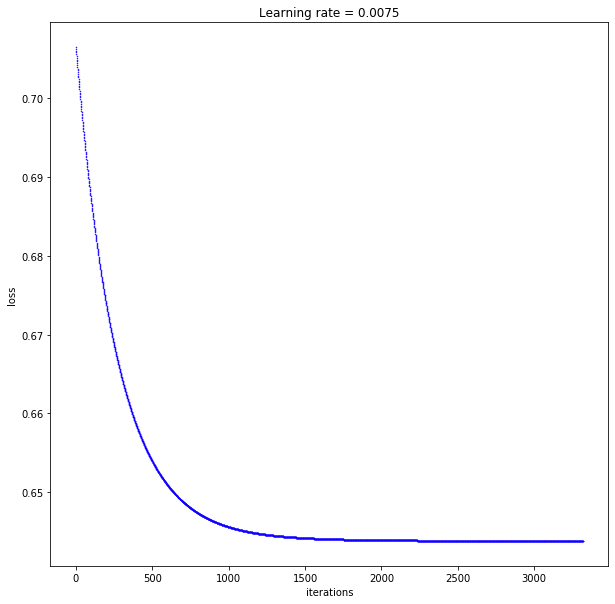

In [14]:
loss = model.history['loss']

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_title('Learning rate = 0.0075')
ax.set_xlabel('iterations')
ax.set_ylabel('loss')
ax.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='')

It's not a cat!


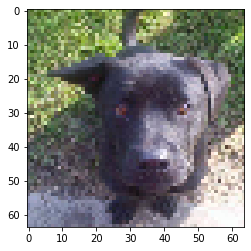

In [15]:
img = np.array(plt.imread("dog.jpg"))
img_ = np.array(Image.fromarray(img).resize((64,64)))
plt.imshow(img_)
img__ = np.reshape(img_,(1,-1))
print("It's{} a cat!".format((1-(model.predict(img__)[0,0]>0.5).astype(int))*' not'))